In [1]:
from __future__ import print_function
import torch
import numpy as np
import math, random
import matplotlib.pyplot as plt


import torch
from torch.autograd import Variable
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.data as Data
dtype = torch.FloatTensor

## Calcul du gradient apres binairisation

On considere $W\in \mathbb{R}^I$ , les parametres reels.

On connait une fonction: $$h_{\epsilon}:\mathbb{R}\longrightarrow\mathbb{R} \qquad \in \mathcal{C}^1$$

$$h_{\epsilon} \sim h(t) = \begin{cases} +1, & \mbox{if } t\mbox{ >0} \\ -1, & \mbox{if } t\mbox{ <0} \end{cases}$$

On definit: $H_{\epsilon}:\mathbb{R}^I\longrightarrow\mathbb{R}^I$, tel que:

$$\forall W\in\mathbb{R}^I, \forall i \in I, H_{\epsilon}(W)_i=h_{\epsilon}(W_i)$$

On note $J_{H_{\epsilon}}(W)$ la matrice Jacobienne de $H_{\epsilon}$ en $W$, on a la differentielle:

\begin{align*}
H_{\epsilon}(W+W') &= (h_{\epsilon}(W_i+W_i'))_{i \in I}\\
                   &= \left (h_{\epsilon}(W_i)+h_{\epsilon}(W'_i)+0(\left\Vert{W'_i}\right\Vert)\right)_{i\in I}
\end{align*}

Donc: $$J_{H_{\epsilon}}(W):  \mathbb{R}^I\longrightarrow\mathbb{R}^I $$

$$W' \longmapsto \left(h'_{\epsilon}(W_i)W'_i\right)_{i\in I}$$

Si on le represente comme une matrice, c'est une matrice diagonale avec les $(h'_{\epsilon}(W'_i))_{i\in I}$ sur la diagonale.

On considere: $$f: \mathbb{R}^I\mapsto \mathbb{R} $$

consistant a calculer la somme des cout des erreurs pour l'echantillon, en $W\in \mathbb{R}^I$. On suppose $f$ etant \mathcal{C}^1

On considere: $$f_{\epsilon}: \mathbb{R}^I \mapsto \mathbb{R}$$ definit par:
$$f_{\epsilon}(W) = f(H_{\epsilon}(W))$$

On a donc $\forall W,W' \in \mathbb{R}^I$:

\begin{align*}
f_{\epsilon}(W+W') &= f(H_{\epsilon}(W+W'))\\
                   &= f\left(H_{\epsilon}(W) + J_{H_{\epsilon}}(W) (W') + 0 \left(\left\Vert W'\right\Vert\right)\right)\\
                   &= f_{\epsilon}(W) + \langle\nabla f(H_{\epsilon}(W)),J_{H_{\epsilon}}(W)(W')\rangle + 0\left(\left\Vert W'\right\Vert\right)
\end{align*}


Ou $\nabla f(H_{\epsilon}(W))$ est simplement le resultat de la Back-Propagation applique avec poid $H_{\epsilon}(W)$.

Finalement, on a:
$$\langle\nabla f\left(H_{\epsilon}(W)\right),J_{H}(W)(W')\rangle = \sum_{i\in I} \nabla f\left(H_{\epsilon}(W)\right)_i h'_{\epsilon}(W_i)W'_i$$

Ainsi:

$$\nabla f_{\epsilon}(W)_i=\nabla f(H_\epsilon(W))_i h'_{\epsilon}(W_i)$$

## Set-up training data and validation data

In [2]:
NUM_EXAMPLES = 2000
TRAIN_SPLIT = .9
np.random.seed(1000) 
NUM_HIDDEN_NODES = 200
EPOCHS = 3000
BATCH_SIZE = 64

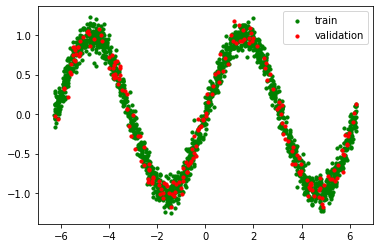

In [3]:


function_to_learn = lambda x: np.sin(x) + 0.1*np.random.randn(*x.shape)
all_x = np.float32(np.random.uniform(-2*np.pi, 2*np.pi, (1, NUM_EXAMPLES))).T
np.random.shuffle(all_x)
train_size = int(NUM_EXAMPLES*TRAIN_SPLIT)

trainx = all_x[:train_size]
trainy = function_to_learn(trainx)
testx = all_x[train_size:]
testy = function_to_learn(testx)

plt.figure(1)
plt.scatter(trainx, trainy,s=10, c='green', label='train')
plt.scatter(testx, testy,s=10, c='red', label='validation')
plt.legend()
plt.show()

In [4]:
x = Variable(torch.FloatTensor(trainx))
y = Variable(torch.FloatTensor(trainy))

## Neural net

In [5]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
        self.hidden1_layer = torch.nn.Linear(H, H)
        self.output_layer = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.input_layer(x).clamp(min=0)
        h_relu1 = F.tanh(self.hidden1_layer(h_relu).clamp(min=0))
        y_pred = self.output_layer(h_relu1)
        return y_pred

In [6]:
# ; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# from (https://github.com/jcjohnson/pytorch-examples)
D_in, H, D_out =  1, NUM_HIDDEN_NODES, 1

model = Net(D_in, H, D_out)


for module in model.modules():
    if hasattr(module, 'weight') and not module.weight is None:
        if not ('BatchNorm' in module.__class__.__name__):
            #need to be placed in constraints
            init.xavier_uniform_(module.weight, gain=1)
        else:
            init.constant_(module.weight, 1)
    if hasattr(module, 'bias'):
        if module.bias is not None:
            init.constant_(module.bias, 0)

In [7]:
criterion = torch.nn.MSELoss(size_average=False)
# need to choose a loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
# need to modify the weight constraints

/home/jvt15/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
for epoch in range(EPOCHS):

    y_pred = model(x)
    loss = criterion(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(epoch%500 == 0):    
        print('Epoch: ',epoch,'--------Loss function:', loss.item())

/home/jvt15/.local/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  0 --------Loss function: 857.53515625
Epoch:  500 --------Loss function: 51.93121337890625
Epoch:  1000 --------Loss function: 37.26470947265625
Epoch:  1500 --------Loss function: 32.09835433959961
Epoch:  2000 --------Loss function: 27.727331161499023
Epoch:  2500 --------Loss function: 24.54015350341797


In [9]:
x = Variable(torch.FloatTensor(testx))
y = Variable(torch.FloatTensor(testy))
y_pred = model(x)


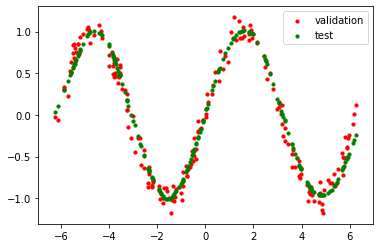

In [10]:
plt.figure(1)
plt.scatter(testx, testy,s=10, c='red', label='validation')
plt.scatter(testx, y_pred.data.numpy(),s=10, c='green', label='test')
plt.legend()

## Discret Function 

In [11]:
NUM_EXAMPLES = 2000
TRAIN_SPLIT = .9
np.random.seed(1000) 
NUM_HIDDEN_NODES = 200
EPOCHS = 3000
BATCH_SIZE = 64

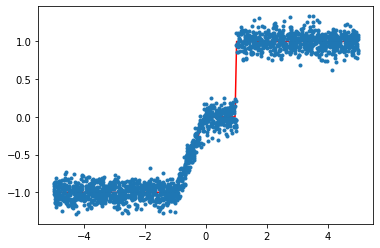

In [12]:
def func4(x):
    y = np.copy(x)
    y[np.where((x<-1))] = -1
    y[np.where((x>0) &(x<1))] = 0
    y[np.where(x>=1)] = 1
    return y
    
Xtest = np.linspace(-5, 5,int(NUM_EXAMPLES*(1-TRAIN_SPLIT)))
Ytest4 = func4(Xtest)

Xlearn = np.random.uniform(-5, 5, size=(NUM_EXAMPLES))
Ylearn4 = func4(Xlearn) + 0.1*np.random.normal(0,1,len(Xlearn))
plt.plot(Xtest, Ytest4,color='r')
plt.plot(Xlearn, Ylearn4,'.', label='Raw input data with noise')
plt.show()

In [13]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.input_layer = torch.nn.Linear(D_in, H)
        self.hidden1_layer = torch.nn.Linear(H, H)
        self.output_layer = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.input_layer(x).clamp(min=0)
        h_relu1 = F.tanh(self.hidden1_layer(h_relu).clamp(min=0))
        y_pred = self.output_layer(h_relu1)
        return y_pred

In [14]:
x = Variable(torch.FloatTensor(Xlearn.reshape(len(Xlearn),1)))
y = Variable(torch.FloatTensor(Ylearn4.reshape(len(Xlearn),1)))

In [15]:
# ; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# from (https://github.com/jcjohnson/pytorch-examples)
D_in, H, D_out =  1, NUM_HIDDEN_NODES, 1

model = Net(D_in, H, D_out)


for module in model.modules():
    if hasattr(module, 'weight') and not module.weight is None:
        if not ('BatchNorm' in module.__class__.__name__):
            #need to be placed in constraints
            init.xavier_uniform_(module.weight, gain=1)
        else:
            init.constant_(module.weight, 1)
    if hasattr(module, 'bias'):
        if module.bias is not None:
            init.constant_(module.bias, 0)

In [16]:
criterion = torch.nn.MSELoss(size_average=False)
# need to choose a loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
# need to modify the weight constraints

In [17]:
for epoch in range(EPOCHS):

    y_pred = model(x)
    loss = criterion(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(epoch%500 == 0):    
        print('Epoch: ',epoch,'--------Loss function:', loss.item())

Epoch:  0 --------Loss function: 1827.7891845703125
Epoch:  500 --------Loss function: 41.32223892211914
Epoch:  1000 --------Loss function: 35.46219253540039
Epoch:  1500 --------Loss function: 29.76974868774414
Epoch:  2000 --------Loss function: 27.97208023071289
Epoch:  2500 --------Loss function: 26.332374572753906


In [18]:
x = Variable(torch.FloatTensor(Xtest.reshape(len(Xtest),1)))
y = Variable(torch.FloatTensor(Ytest4.reshape(len(Xtest),1)))
y_pred = model(x)

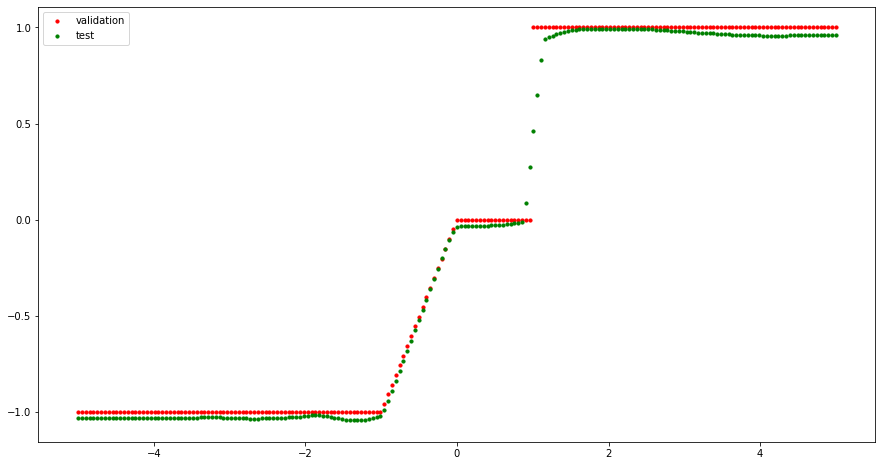

In [19]:
plt.figure(figsize=(15,8))
plt.scatter(Xtest, Ytest4,s=10, c='red', label='validation')
plt.scatter(Xtest, y_pred.data.numpy(),s=10, c='green', label='test')
plt.legend()

## With batch-size

In [20]:
NUM_EXAMPLES = 2000
TRAIN_SPLIT = .9
np.random.seed(1000) 
NUM_HIDDEN_NODES = 200
EPOCHS = 3000
BATCH_SIZE = 400

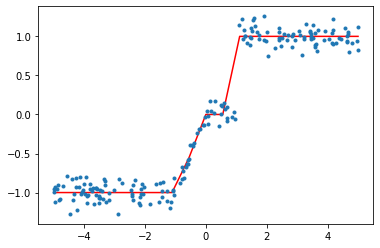

In [157]:
def func4(x):
    y = np.copy(x)
    y[np.where((x<-1))] = -1
    y[np.where((x>0) &(x<1))] = 0
    y[np.where(x>=1)] = 1
    return y
    
Xtest = np.linspace(-5, 5,int(NUM_EXAMPLES*(1-TRAIN_SPLIT)))
Ytest4 = func4(Xtest)

Xlearn = np.random.uniform(-5, 5, size=(NUM_EXAMPLES))
Ylearn4 = func4(Xlearn) + 0.1*np.random.normal(0,1,len(Xlearn))
plt.plot(Xtest, Ytest4,color='r')
plt.plot(Xlearn, Ylearn4,'.', label='Raw input data with noise')
plt.show()


x = Variable(torch.FloatTensor(Xlearn.reshape(len(Xlearn),1)))
y = Variable(torch.FloatTensor(Ylearn4.reshape(len(Xlearn),1)))

In [158]:
# ; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
# from (https://github.com/jcjohnson/pytorch-examples)
D_in, H, D_out =  1, NUM_HIDDEN_NODES, 1

model = Net(D_in, H, D_out)


for module in model.modules():
    if hasattr(module, 'weight') and not module.weight is None:
        if not ('BatchNorm' in module.__class__.__name__):
            #need to be placed in constraints
            init.xavier_uniform_(module.weight, gain=1)
        else:
            init.constant_(module.weight, 1)
    if hasattr(module, 'bias'):
        if module.bias is not None:
            init.constant_(module.bias, 0)

In [159]:
criterion = torch.nn.MSELoss(size_average=False)
# need to choose a loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
# need to modify the weight constraints

In [160]:
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=2,)

In [161]:
for epoch in range(EPOCHS):
    for step, (batch_x, batch_y) in enumerate(loader):
        y_pred = model(batch_x)
        loss = criterion(y_pred,batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if(epoch%500 == 0):    
        print('Epoch: ',epoch,'--------Loss function:', loss.item())
        

/home/jvt15/.local/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  0 --------Loss function: 2.896630048751831


In [162]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[ 0.1439],
        [-0.0629],
        [-0.0608],
        [ 0.2369],
        [-0.0343],
        [-0.0839],
        [-0.2296],
        [-0.0065],
        [ 0.0588],
        [-0.2541],
        [ 0.2740],
        [ 0.3123],
        [ 0.1839],
        [-0.1275],
        [-0.3037],
        [ 0.2618],
        [ 0.2179],
        [-0.1046],
        [ 0.0657],
        [-0.1317],
        [-0.0147],
        [-0.0076],
        [ 0.2017],
        [ 0.0796],
        [ 0.0714],
        [ 0.2788],
        [ 0.1365],
        [-0.2458],
        [ 0.2416],
        [ 0.3128],
        [-0.0455],
        [ 0.2169],
        [-0.0403],
        [ 0.2745],
        [ 0.2688],
        [-0.1417],
        [-0.1897],
        [-0.1039],
        [ 0.1744],
        [ 0.2037],
        [-0.1826],
        [-0.0724],
        [ 0.0617],
        [ 0.2132],
        [-0.1862],
        [ 0.3145],
        [ 0.0412],
        [-0.1656],
        [-0.2903],
        [ 0.2904]], requires_grad=True)
Paramet

In [27]:
for module in model.modules():
    print(module)

Net(
  (input_layer): Linear(in_features=1, out_features=200, bias=True)
  (hidden1_layer): Linear(in_features=200, out_features=200, bias=True)
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
Linear(in_features=1, out_features=200, bias=True)
Linear(in_features=200, out_features=200, bias=True)
Linear(in_features=200, out_features=1, bias=True)


In [28]:
for param in model.parameters():
    print(param.shape)

torch.Size([200, 1])
torch.Size([200])
torch.Size([200, 200])
torch.Size([200])
torch.Size([1, 200])
torch.Size([1])


## Forward binary step

In [132]:
NUM_EXAMPLES = 200
TRAIN_SPLIT = .9
np.random.seed(1000) 
NUM_HIDDEN_NODES = 50
EPOCHS = 1
BATCH_SIZE = 1

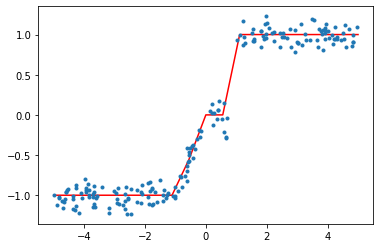

In [133]:
def func4(x):
    y = np.copy(x)
    y[np.where((x<-1))] = -1
    y[np.where((x>0) &(x<1))] = 0
    y[np.where(x>=1)] = 1
    return y
    
Xtest = np.linspace(-5, 5,int(NUM_EXAMPLES*(1-TRAIN_SPLIT)))
Ytest4 = func4(Xtest)

Xlearn = np.random.uniform(-5, 5, size=(NUM_EXAMPLES))
Ylearn4 = func4(Xlearn) + 0.1*np.random.normal(0,1,len(Xlearn))
plt.plot(Xtest, Ytest4,color='r')
plt.plot(Xlearn, Ylearn4,'.', label='Raw input data with noise')
plt.show()


x = Variable(torch.FloatTensor(Xlearn.reshape(len(Xlearn),1)))
y = Variable(torch.FloatTensor(Ylearn4.reshape(len(Xlearn),1)))

torch_train_dataset = Data.TensorDataset(x, y)
train_loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

x = Variable(torch.FloatTensor(Xtest.reshape(len(Xtest),1)))
y = Variable(torch.FloatTensor(Ytest4.reshape(len(Xtest),1)))

torch_validate_dataset = Data.TensorDataset(x, y)
test_loader = Data.DataLoader(
    dataset = torch_validate_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,num_workers=2,)

In [134]:
def forward(data_loader, model, criterion, epoch=0, training=True
            , optimizer=None):
    for i, (inputs, target) in enumerate(data_loader):
        
        output_prediction = model(inputs)
        loss = criterion(output_prediction, target)
        
        if training:
            optimizer.zero_grad()
            loss.backward()
            for p in list(model.parameters()):
                if hasattr(p,'org'):
                    p.data.copy_(p.org)
            optimizer.step()
            for p in list(model.parameters()):
                if hasattr(p,'org'):
                    p.org.copy_(p.data.clamp_(-1,1))
        
    return loss

def train(data_loader, model, criterion, epoch, optimizer):
    model.train()
    return forward(data_loader,model,criterion,epoch,training=True,
                   optimizer=optimizer)

def validate(data_loader, model, criterion, epoch, training=False,optimizer=None):
    model.eval()
    return forward(data_loader, model, criterion, epoch, training=False,
                  optimizer = None)

In [135]:
def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
        return tensor.sign()
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

    
class BinarizeLinear(torch.nn.Linear):
    def __init__(self,*kargs,**kwargs):
        super(BinarizeLinear,self).__init__(*kargs,**kwargs)
        
    def forward(self,input):
        input.data = Binarize(input.data)
 
        if not hasattr(self.weight,'org'):
            self.weight.org = self.weight.data.clone()
        self.weight.data = Binarize(self.weight.org)
        out = torch.nn.functional.linear(input,self.weight)
        
        if not self.bias is None:
            self.bias.org = self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)
        return out

In [144]:
class Binary_Net(torch.nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Binary_Net,self).__init__()
        self.features = torch.nn.Sequential(
        BinarizeLinear(D_in,H,bias=True),
#         torch.nn.BatchNorm1d(H),
#         torch.nn.Hardtanh(inplace=True),
        BinarizeLinear(H,D_out,bias=True)    
        )
        
        
#         self.regime = {
#             0: {'optimizer': 'Adam', 'betas': (0.9, 0.999),'lr': 1e-3},
#             40: {'lr': 1e-3},
#             80: {'lr': 5e-4},
#             100: {'lr': 1e-4},
#             120: {'lr': 5e-5},
#             140: {'lr': 1e-5}
#         }
        
    def forward(self, x):
        x = self.features(x)
        return x


In [145]:
D_in, H, D_out =  1, NUM_HIDDEN_NODES, 1

model = Binary_Net(D_in, H, D_out)

In [146]:
NUM_HIDDEN_NODES

50

In [147]:
model

Binary_Net(
  (features): Sequential(
    (0): BinarizeLinear(in_features=1, out_features=50, bias=True)
    (1): BinarizeLinear(in_features=50, out_features=1, bias=True)
  )
)

In [148]:
for param in model.parameters():
    print(param.shape)

torch.Size([50, 1])
torch.Size([50])
torch.Size([1, 50])
torch.Size([1])


In [153]:
criterion = torch.nn.MSELoss(size_average=False)
# need to choose a loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# need to modify the weight constraints

/home/jvt15/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [154]:
for epoch in range(EPOCHS):
    
    train_loss = train(train_loader, model, criterion, epoch, optimizer)
    
    val_loss   = validate(test_loader, model, criterion, epoch)
    
    

    if(epoch%1 == 0):    
        print('Epoch: ',epoch,'--------Loss function:', loss.item())

Epoch:  0 --------Loss function: 4.786065578460693


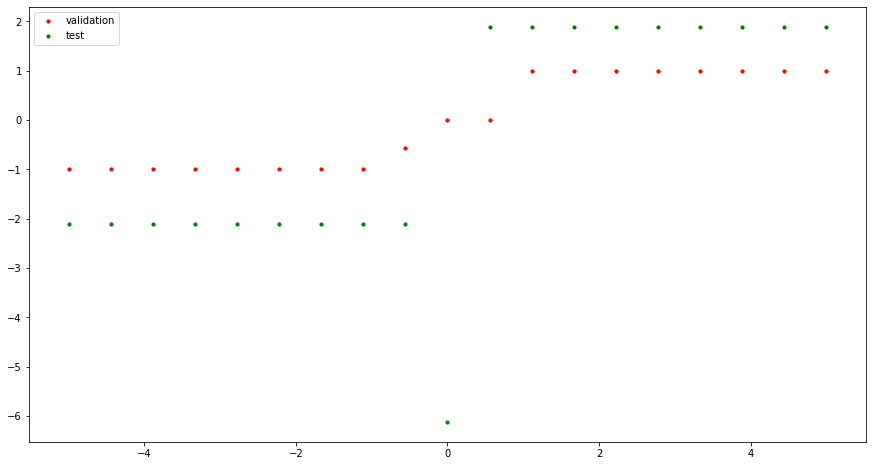

In [155]:
y_pred = model(x)
plt.figure(figsize=(15,8))
plt.scatter(Xtest, Ytest4,s=10, c='red', label='validation')
plt.scatter(Xtest, y_pred.data.numpy(),s=10, c='green', label='test')
plt.legend()

In [156]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.]], requires_grad=True)
Parameter containing:
tensor([-0.3598,  0.2191, -0.2611,  0.7419, -0.6927, -0.7446,  0.8755,  0.0668,
         0.1969, -0.2989,  0.5806, -0.6225,  0.0679, -0.7176,  0.6007, -0.7155,
        -0.2288,  0.7067,